# DataKind Red Cross Project Phase 2
## Home Fire Risk Data Model
10/28/2019
Tasks:
1. <b>Home Fire County Assessment</b>: Score and rank order counties based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
2. <b>Home Fire Census Tract Assessment</b>: Score and rank order census tracts based on highest fire rates per-capita using NFIRS Data (aggregate) and SVI population estimates
3. <b>Home Fire Severity Assessment (county)</b>: Score and rank order counties based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates.
4. <b>Home Fire Severity Assessment (census tract</b>Score and rank order census tracts based on rates of severe fires per-capita using NFIRS Data (aggregate) and SVI population estimates
5. <b>Home Fire Predictablility Assessment</b>: Using Census Tract Fire Severity Assesment bin Data at 3-month 6-month or 1-year intervals and train simple linear/logistic regression model

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns',500)
sns.set()

# NFIRS Data

First, make sure that I import the dataset correctly and get the column dtypes correct so that data isn't lost (for id numbers with leading zeros for example)

In [58]:
nfirs_path = '../data/01_raw/NFIRS_2009_2016_Combined_Census_Tract.csv'

cols_to_use = ['inc_date','oth_inj','oth_death','prop_loss',
               'cont_loss','tot_loss','GEOID']
col_dtypes = {'GEOID':str}

nfirs = pd.read_csv(nfirs_path,
                    dtype = col_dtypes,
                    usecols = cols_to_use,
                    encoding='latin-1')

nfirs['inc_date'] = pd.to_datetime(nfirs['inc_date'], infer_datetime_format=True)

In [62]:
nfirs.sample(5)

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID
1527949,2015-03-24,NaN,NaN,3000.0,0.0,153926.0,37031970604.0
704957,2011-08-13,1.0,0.0,0.0,0.0,0.0,48027021202.0
800474,2012-01-05,NaN,NaN,10.0,10.0,20.0,17163500900.0
1673657,2015-11-15,NaN,NaN,0.0,500.0,327500.0,2150000300.0
145552,2009-02-23,0.0,0.0,0.0,0.0,0.0,36061001300.0


## Fix GEOIDs (add leading zeros to correct columns)
It seems that a lot of the GEOIDs are missing the leading 0. For now I'm just going to add a leading 0 if the GEOID length is 10.

In [63]:
nfirs['GEOID'].str.len().value_counts()

13.0    1442479
12.0     196432
Name: GEOID, dtype: int64

In [64]:
nfirs['GEOID'] = (nfirs['GEOID'].str[:-2]
                  .str.zfill(11))

In [65]:
nfirs.head()

,inc_date,oth_inj,oth_death,prop_loss,cont_loss,tot_loss,GEOID
0,2009-01-03,0.0,0.0,20000.0,5000.0,25000.0,02110000500
1,2009-01-06,0.0,0.0,0.0,0.0,0.0,02110000600
2,2009-01-06,0.0,0.0,20000.0,5000.0,25000.0,02110000100
3,2009-01-13,0.0,0.0,200.0,20.0,220.0,02110000400
4,2009-01-21,0.0,0.0,35000.0,5000.0,40000.0,02110000400


In [66]:
# Add a year column to be used to groupby in addition to GEOID
nfirs['year'] = nfirs['inc_date'].dt.year

# SVI Data

In [69]:
svi2016_path = '../data/01_raw/SVI2016_US.csv'
svi2016_top = pd.read_csv(svi2016_path,nrows=1000)

svi_col_dtypes = {'ST':str,'STCNTY':str,'FIPS':str}

svi2016 = pd.read_csv(svi2016_path,
                     index_col=0,
                     dtype = svi_col_dtypes)

In [131]:
svi2016.head(3)

,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
FID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,01,ALABAMA,AL,01015,Calhoun,01015981902,"Census Tract 9819.02, Calhoun County, Alabama",34.644448,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,335.0
1,01,ALABAMA,AL,01015,Calhoun,01015981903,"Census Tract 9819.03, Calhoun County, Alabama",13.929908,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0
2,01,ALABAMA,AL,01097,Mobile,01097990000,"Census Tract 9900, Mobile County, Alabama",0.000000,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,-999.0,-999.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,11.0,0.0,15.6,0.0,15.6,0.0,44.0,0.0,15.6,0.0,11.0,0.0,15.6,0.0,11.0,0.0,11.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,0.0,11.0,-999.0,-999.0,0.0


# Aggregate NFIRS and SVI Data

1. Add severe_fire column (severe fire = either fatality, injury, or fire damage in excess of $10,000)
2. Aggregate nfirs by county, svi by county, and merge
3. Aggregate nfirs by census tract, svi by census tract (which it's already at), and merge

In [135]:
# Add the severe fire column to the dataset
sev_fire_mask = (nfirs['oth_death'] > 0) | (nfirs['oth_inj'] > 0) | (nfirs['tot_loss'] >= 10000)
nfirs['severe_fire'] = 'not_sev_fire'
nfirs.loc[sev_fire_mask,'severe_fire'] = 'sev_fire'

In [136]:
# add the state+county unique identifier column to nfirs
nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# Do frequency counts based on the year & the number of severe vs non-severe fires
nfirs_counties = pd.crosstab(nfirs['STCNTY'],[nfirs['year'],nfirs['severe_fire']])

# Iterate through years and calculate the total number of fires
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_counties[(year,'tot_fires')] = nfirs_counties[(year,'not_sev_fire')] + nfirs_counties[(year,'sev_fire')]

# Sort the columns
nfirs_counties = nfirs_counties[sorted(nfirs_counties.columns)]

# aggregate svi data by county
svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# add nfirs data to svi data and insure it's a one-to-one merge
nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

nfirs_svi_counties_rates = nfirs_svi_counties[['E_TOTPOP']].copy()

# Calculate the per capita fire rates
for year in [2009,2010,2011,2012,2013,2014,2015,2016]:
    nfirs_svi_counties_rates[str(year) + '_tot_fire_rate_per_cap'] = nfirs_svi_counties[(year,'tot_fires')] / nfirs_svi_counties['E_TOTPOP']
    nfirs_svi_counties_rates[str(year) + '_sev_fire_rate_per_cap'] = nfirs_svi_counties[(year,'sev_fire')] / nfirs_svi_counties['E_TOTPOP']

# Add the county and state columns to the dataset
nfirs_svi_counties_rates = nfirs_svi_counties_rates.merge(svi2016[['COUNTY','STATE','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
nfirs_svi_counties_rates = nfirs_svi_counties_rates.set_index('STCNTY')

C:\Users\thwhi\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [137]:
nfirs_svi_counties_rates.head()

,E_TOTPOP,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap,COUNTY,STATE
STCNTY,,,,,,,,,,,,,,,,,,,
01001,55049.0,0.000708,0.000236,0.000490,0.000163,0.000527,0.000127,0.000254,0.000036,0.000436,0.000073,0.000200,0.000036,0.000563,0.000545,0.000490,0.000145,Autauga,ALABAMA
01003,199510.0,0.000366,0.000080,0.000471,0.000075,0.000381,0.000100,0.000441,0.000065,0.000396,0.000050,0.000677,0.000125,0.000501,0.000501,0.000486,0.000075,Baldwin,ALABAMA
01005,26614.0,0.000376,0.000113,0.000451,0.000000,0.000150,0.000000,0.000301,0.000188,0.000038,0.000000,0.000338,0.000225,0.000113,0.000113,0.000188,0.000038,Barbour,ALABAMA
01007,22572.0,0.000044,0.000044,0.000044,0.000044,0.000089,0.000044,0.000177,0.000044,0.000000,0.000000,0.000000,0.000000,0.000089,0.000089,0.000133,0.000089,Bibb,ALABAMA
01009,57704.0,0.000364,0.000069,0.000399,0.000069,0.000468,0.000243,0.000277,0.000087,0.000208,0.000069,0.000295,0.000069,0.000277,0.000277,0.000832,0.000087,Blount,ALABAMA


In [104]:
sev_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('sev_')]
tot_cols = nfirs_svi_counties_rates.columns[nfirs_svi_counties_rates.columns.str.contains('tot_')]

In [105]:
nfirs_svi_counties_rates['sev_avg'] = nfirs_svi_counties_rates[sev_cols].mean(axis=1)
nfirs_svi_counties_rates['sev_std'] = nfirs_svi_counties_rates[sev_cols].std(axis=1)

nfirs_svi_counties_rates['tot_avg'] = nfirs_svi_counties_rates[tot_cols].mean(axis=1)
nfirs_svi_counties_rates['tot_std'] = nfirs_svi_counties_rates[tot_cols].std(axis=1)

In [107]:
nfirs_svi_counties_rates.sort_values('tot_avg',ascending=False).head()

,E_TOTPOP,2009_tot_fire_rate_per_cap,2009_sev_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2010_sev_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2011_sev_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2012_sev_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2013_sev_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2014_sev_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2015_sev_fire_rate_per_cap,2016_tot_fire_rate_per_cap,2016_sev_fire_rate_per_cap,COUNTY,STATE,sev_avg,tot_avg,sev_std,tot_std
STCNTY,,,,,,,,,,,,,,,,,,,,,,,
25025,767719.0,0.004113,0.000223,0.004129,0.000225,0.004004,0.000225,0.003859,0.000215,0.004094,0.000276,0.004298,0.000225,0.004001,0.003699,0.004645,0.000242,Suffolk,MASSACHUSETTS,0.000666,0.004143,0.001226,0.000239
36005,1436785.0,0.003026,0.000026,0.003064,0.000032,0.002359,0.000023,0.002431,0.000031,0.002946,0.000040,0.003227,0.000031,0.003167,0.000470,0.003171,0.000047,Bronx,NEW YORK,0.000088,0.002924,0.000155,0.000339
05069,72385.0,0.002349,0.000815,0.003260,0.001299,0.002956,0.000995,0.003081,0.001188,0.002929,0.000939,0.003398,0.001243,0.003205,0.003191,0.001119,0.000152,Jefferson,ARKANSAS,0.001228,0.002787,0.000872,0.000745
28119,7634.0,0.002620,0.000655,0.002358,0.001048,0.001703,0.000655,0.003668,0.001310,0.002227,0.001048,0.002227,0.000655,0.003144,0.003144,0.003537,0.001572,Quitman,MISSISSIPPI,0.001261,0.002685,0.000831,0.000697
05095,7542.0,0.003050,0.001061,0.001326,0.000663,0.002519,0.001193,0.002652,0.001724,0.002519,0.001724,0.003580,0.001326,0.003182,0.003182,0.001458,0.000663,Monroe,ARKANSAS,0.001442,0.002536,0.000813,0.000794


In [130]:
nfirs_svi_counties_rates.sort_values('tot_avg',ascending=False)[tot_cols].head()

,2009_tot_fire_rate_per_cap,2010_tot_fire_rate_per_cap,2011_tot_fire_rate_per_cap,2012_tot_fire_rate_per_cap,2013_tot_fire_rate_per_cap,2014_tot_fire_rate_per_cap,2015_tot_fire_rate_per_cap,2016_tot_fire_rate_per_cap
STCNTY,,,,,,,,
25025,0.004113,0.004129,0.004004,0.003859,0.004094,0.004298,0.004001,0.004645
36005,0.003026,0.003064,0.002359,0.002431,0.002946,0.003227,0.003167,0.003171
05069,0.002349,0.003260,0.002956,0.003081,0.002929,0.003398,0.003205,0.001119
28119,0.002620,0.002358,0.001703,0.003668,0.002227,0.002227,0.003144,0.003537
05095,0.003050,0.001326,0.002519,0.002652,0.002519,0.003580,0.003182,0.001458


In [76]:
# # aggregate nfirs by county. Though about 1/8 of the geoids are NaN, so this will skip those values for now.
# # Perhaps before finalizing this analysis we should try and add the missing geographic data, and at least 
# # get the county and census tract for each location, that should be pretty straightforward.

# # Create the STCNTY column from the geoid column
# nfirs['STCNTY'] = nfirs['GEOID'].str[:5]

# # Frequency table for severe vs. non-severe fires by tract
# nfirs_counties = pd.crosstab(nfirs['STCNTY'],nfirs['severe_fire'])
# nfirs_counties.columns = ['non-severe_fires','severe_fires']
# nfirs_counties['tot_fires'] = nfirs_counties.sum(axis=1)

# # aggregate svi data by county
# svi2016_counties = svi2016.groupby('STCNTY').agg({'E_TOTPOP':'sum'})

# # add nfirs data to svi data and insure it's a one-to-one merge
# nfirs_svi_counties = svi2016_counties.merge(nfirs_counties,how='left',left_index=True,right_index=True, validate='one_to_one')

# # Calculate the per capita fire rate and severe fire rate
# nfirs_svi_counties['fire_rate_per_capita'] = nfirs_svi_counties['tot_fires'] / nfirs_svi_counties['E_TOTPOP']
# nfirs_svi_counties['severe_fire_rate_per_capita'] = nfirs_svi_counties['severe_fires'] / nfirs_svi_counties['E_TOTPOP']

# # Add the county and state columns to the dataset
# nfirs_svi_counties = nfirs_svi_counties.merge(svi2016[['COUNTY','STATE','STCNTY']].drop_duplicates(subset='STCNTY'),how='left',left_index=True,right_on='STCNTY')
# nfirs_svi_counties = nfirs_svi_counties.set_index('STCNTY')

In [77]:
nfirs_svi_counties.sort_values('fire_rate_per_capita',ascending=False).head()

,E_TOTPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita,COUNTY,STATE
STCNTY,,,,,,,,
25025,767719.0,21353.0,4093.0,25446.0,0.033145,0.005331,Suffolk,MASSACHUSETTS
36005,1436785.0,32600.0,1007.0,33607.0,0.023390,0.000701,Bronx,NEW YORK
05069,72385.0,903.0,711.0,1614.0,0.022297,0.009822,Jefferson,ARKANSAS
28119,7634.0,87.0,77.0,164.0,0.021483,0.010086,Quitman,MISSISSIPPI
05095,7542.0,66.0,87.0,153.0,0.020286,0.011535,Monroe,ARKANSAS


In [78]:
nfirs_svi_counties.sort_values('severe_fire_rate_per_capita',ascending=False).head()

,E_TOTPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita,COUNTY,STATE
STCNTY,,,,,,,,
05095,7542.0,66.0,87.0,153.0,0.020286,0.011535,Monroe,ARKANSAS
28119,7634.0,87.0,77.0,164.0,0.021483,0.010086,Quitman,MISSISSIPPI
05069,72385.0,903.0,711.0,1614.0,0.022297,0.009822,Jefferson,ARKANSAS
51730,31997.0,329.0,288.0,617.0,0.019283,0.009001,Petersburg City,VIRGINIA
05093,44199.0,489.0,389.0,878.0,0.019865,0.008801,Mississippi,ARKANSAS


In [79]:
nfirs_svi_counties.describe().round(5)

,E_TOTPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita
count,3.142000e+03,3013.00000,3013.00000,3013.00000,3013.00000,3013.00000
mean,1.013871e+05,384.23399,159.71258,543.94656,0.00466,0.00170
std,3.252017e+05,1645.14029,492.34244,1996.57539,0.00329,0.00137
min,7.600000e+01,0.00000,0.00000,1.00000,0.00004,0.00000
25%,1.099650e+04,19.00000,11.00000,34.00000,0.00231,0.00073
50%,2.573750e+04,73.00000,43.00000,121.00000,0.00415,0.00144
75%,6.758325e+04,230.00000,129.00000,369.00000,0.00638,0.00230
max,1.005716e+07,45215.00000,13522.00000,46586.00000,0.03314,0.01154


# Aggregate by census tract now

In [80]:
# # Get the geoid to the tract level
# nfirs['GEOID_'] = nfirs['GEOID'].str[:11]

# Frequency table for severe vs. non-severe fires by tract
nfirs_tracts = pd.crosstab(nfirs['GEOID'],nfirs['severe_fire'])
nfirs_tracts.columns = ['non-severe_fires','severe_fires']
nfirs_tracts['tot_fires'] = nfirs_tracts.sum(axis=1)

# aggregate svi data by county
svi2016_tracts = svi2016.groupby('FIPS').agg({'E_TOTPOP':'sum'})

# Merge those datasets and insure that it's a one-to-one merge
nfirs_svi_tracts = svi2016_tracts.merge(nfirs_tracts,how='left',left_index=True,right_index=True,validate='one_to_one')

# Calculate the per capita fire rate and severe fire rate
nfirs_svi_tracts['fire_rate_per_capita'] = nfirs_svi_tracts['tot_fires'] / nfirs_svi_tracts['E_TOTPOP']
nfirs_svi_tracts['severe_fire_rate_per_capita'] = nfirs_svi_tracts['severe_fires'] / nfirs_svi_tracts['E_TOTPOP']

# Add the location to the dataset
nfirs_svi_tracts = nfirs_svi_tracts.merge(svi2016[['FIPS','LOCATION']],how='left',left_index=True,right_on='FIPS')
nfirs_svi_tracts = nfirs_svi_tracts.set_index('FIPS')

# Fix the errors where a census tract had 0 population but still had fires, so the rates were infinite
nfirs_svi_tracts['fire_rate_per_capita'] = nfirs_svi_tracts['fire_rate_per_capita'].replace(np.inf,np.nan)
nfirs_svi_tracts['severe_fire_rate_per_capita'] = nfirs_svi_tracts['severe_fire_rate_per_capita'].replace(np.inf,np.nan)

In [81]:
nfirs_svi_tracts.sort_values('fire_rate_per_capita',ascending=False).head()

,E_TOTPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita,LOCATION
FIPS,,,,,,,
36119000104,20.0,22.0,7.0,29.0,1.450000,0.350000,"Census Tract 1.04, Westchester County, New York"
36061021703,8.0,7.0,0.0,7.0,0.875000,0.000000,"Census Tract 217.03, New York County, New York"
36061014300,5.0,3.0,0.0,3.0,0.600000,0.000000,"Census Tract 143, New York County, New York"
36061009400,44.0,20.0,0.0,20.0,0.454545,0.000000,"Census Tract 94, New York County, New York"
48201980000,9.0,2.0,2.0,4.0,0.444444,0.222222,"Census Tract 9800, Harris County, Texas"


In [82]:
nfirs_svi_tracts.sort_values('severe_fire_rate_per_capita',ascending=False).head()

,E_TOTPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita,LOCATION
FIPS,,,,,,,
36119000104,20.0,22.0,7.0,29.0,1.450000,0.350000,"Census Tract 1.04, Westchester County, New York"
48201980000,9.0,2.0,2.0,4.0,0.444444,0.222222,"Census Tract 9800, Harris County, Texas"
26099982000,5.0,0.0,1.0,1.0,0.200000,0.200000,"Census Tract 9820, Macomb County, Michigan"
06083980000,8.0,0.0,1.0,1.0,0.125000,0.125000,"Census Tract 9800, Santa Barbara County, Calif..."
26163508100,1155.0,51.0,128.0,179.0,0.154978,0.110823,"Census Tract 5081, Wayne County, Michigan"


## Task 5: Home Fire Predictability Assessment

We'd have to bin the data by date before we aggregate it. We'd also have to be cognizant that the SVI data is for 2012-2016, and that there are several other SVI datasets too (that have slightly different formatting)

# Group B Tasks
1. <b>HFC Home Visit Area Profiles</b>: Use SVI data to identify common demographic and economic themes for Census Tract areas where alarms were installed. Document methodology and results
2. <b>Home Fire Area Profiles</b>: Use SVI data to identify common demographic and economic themes for Census Tract areas reporting fires. Document methodolgy and results
3. <b>Lives Saved Area Profiles</b>: Use SVI data to identify common themes for Lives Saved Locations. Document methodology and results

# Task B2: Home Fire Area Profiles

In [83]:
svi2016_withfires = svi2016.merge(nfirs_svi_tracts.drop(['LOCATION','E_TOTPOP'],axis=1),how='left',left_on='FIPS',right_index=True,validate='one_to_one')

In [84]:
svi2016_withfires=svi2016_withfires.set_index('FIPS')
svi2016_withfires=svi2016_withfires.sort_index()

In [85]:
svi2016_withfires=svi2016_withfires.replace(-999.0,np.nan)

In [86]:
svi2016_withfires.head()

,ST,STATE,ST_ABBR,STCNTY,COUNTY,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV,M_POV,E_UNEMP,M_UNEMP,E_PCI,M_PCI,E_NOHSDP,M_NOHSDP,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_MINRTY,M_MINRTY,E_LIMENG,M_LIMENG,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV,MP_POV,EP_UNEMP,MP_UNEMP,EP_PCI,MP_PCI,EP_NOHSDP,MP_NOHSDP,EP_AGE65,MP_AGE65,EP_AGE17,MP_AGE17,EP_DISABL,MP_DISABL,EP_SNGPNT,MP_SNGPNT,EP_MINRTY,MP_MINRTY,EP_LIMENG,MP_LIMENG,EP_MUNIT,MP_MUNIT,EP_MOBILE,MP_MOBILE,EP_CROWD,MP_CROWD,EP_NOVEH,MP_NOVEH,EP_GROUPQ,MP_GROUPQ,EPL_POV,EPL_UNEMP,EPL_PCI,EPL_NOHSDP,SPL_THEME1,RPL_THEME1,EPL_AGE65,EPL_AGE17,EPL_DISABL,EPL_SNGPNT,SPL_THEME2,RPL_THEME2,EPL_MINRTY,EPL_LIMENG,SPL_THEME3,RPL_THEME3,EPL_MUNIT,EPL_MOBILE,EPL_CROWD,EPL_NOVEH,EPL_GROUPQ,SPL_THEME4,RPL_THEME4,SPL_THEMES,RPL_THEMES,F_POV,F_UNEMP,F_PCI,F_NOHSDP,F_THEME1,F_AGE65,F_AGE17,F_DISABL,F_SNGPNT,F_THEME2,F_MINRTY,F_LIMENG,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,non-severe_fires,severe_fires,tot_fires,fire_rate_per_capita,severe_fire_rate_per_capita
FIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
01001020100,01,ALABAMA,AL,01001,Autauga,"Census Tract 201, Autauga County, Alabama",3.792610,2010.0,231.0,751.0,62.0,740.0,62.0,199.0,129.0,43.0,31.0,28528.0,5010.0,167.0,95.0,172.0,64.0,456.0,126.0,211.0,73.0,68.0,47.1,395.0,344.8,16.0,47.5,0.0,15.6,79.0,43.0,3.0,12.1,15.0,20.0,0.0,11.0,9.9,6.3,4.2,3.0,28528.0,5010.0,12.9,7.0,8.6,3.0,22.7,5.7,10.5,3.9,9.2,6.3,19.7,17.0,0.8,2.5,0.0,2.1,10.5,5.8,0.4,1.6,2.0,2.7,0.0,0.5,0.3771,0.2157,0.4192,0.5848,1.5968,0.3886,0.1646,0.5109,0.3521,0.5698,1.5974,0.2354,0.3839,0.4084,0.7923,0.3855,0.0000,0.7923,0.2098,0.1835,0.0000,1.1857,0.1048,5.1721,0.1919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222.0,83.0,11.0,4.3,1157.0,6.0,7.0,13.0,0.006468,0.003483
01001020200,01,ALABAMA,AL,01001,Autauga,"Census Tract 202, Autauga County, Alabama",1.290309,2196.0,281.0,890.0,93.0,838.0,100.0,483.0,210.0,72.0,42.0,19497.0,2760.0,274.0,107.0,272.0,51.0,478.0,115.0,404.0,118.0,70.0,46.3,1231.0,302.1,19.0,46.9,24.0,22.0,17.0,15.0,17.0,22.8,92.0,46.0,177.0,77.0,24.0,9.4,7.8,4.5,19497.0,2760.0,18.7,7.2,12.4,2.4,21.8,4.4,20.0,5.1,8.4,5.4,56.1,11.7,0.9,2.2,2.7,2.5,1.9,1.7,2.0,2.7,11.0,5.4,8.1,3.4,0.7822,0.5936,0.7663,0.7520,2.8941,0.7713,0.3707,0.4419,0.8787,0.5130,2.2043,0.6242,0.7294,0.4193,1.1487,0.5978,0.4252,0.5995,0.5267,0.7404,0.9367,3.2285,0.8594,9.4756,0.8104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,209.0,85.0,10.4,4.2,4126.0,10.0,7.0,17.0,0.007741,0.003188
01001020300,01,ALABAMA,AL,01001,Autauga,"Census Tract 203, Autauga County, Alabama",2.065365,3136.0,355.0,1422.0,76.0,1223.0,116.0,337.0,177.0,76.0,50.0,22439.0,2544.0,251.0,106.0,550.0,100.0,701.0,198.0,756.0,160.0,49.0,44.4,1031.0,490.9,96.0,108.1,6.0,14.2,5.0,11.0,25.0,27.3,148.0,71.0,0.0,11.0,10.7,5.5,5.1,3.3,22439.0,2544.0,11.3,4.4,17.5,3.4,22.4,5.8,24.2,4.3,4.0,3.6,32.9,15.2,3.1,3.5,0.4,1.0,0.4,0.8,2.0,2.2,12.1,5.5,0.0,0.4,0.4117,0.3159,0.6506,0.5225,1.9007,0.4824,0.6873,0.4860,0.9561,0.1739,2.3032,0.6873,0.5478,0.6689,1.2167,0.6365,0.2413,0.4317,0.5288,0.7682,0.0000,1.9700,0.3407,7.3906,0.5264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,236.0,99.0,7.5,3.0,1960.0,13.0,12.0,25.0,0.007972,0.003827
01001020400,01,ALABAMA,AL,01001,Autauga,"Census Tract 204, Autauga County, Alabama",2.464376,4563.0,464.0,1951.0,94.0,1776.0,152.0,125.0,97.0,190.0,107.0,24451.0,2827.0,349.0,135.0,1030.0,149.0,1075.0,230.0,802.0,190.0,90.0,53.1,913.0,615.9,76.0,69.1,82.0,87.3,0.0,11.0,12.0,17.8,12.0,20.0,0.0,11.0,2.7,2.2,9.3,4.7,24451.0,2827.0,11.3,4.0,22.6,3.4,23.6,4.4,17.7,3.8,5.1,3.0,20.0,13.3,1.7,1.6,4.2,4.5,0.0,1.5,0.7,1.0,0.7,1.1,0.0,0.2,0.0520,0.7043,0.5696,0.522

(0, 0.2)

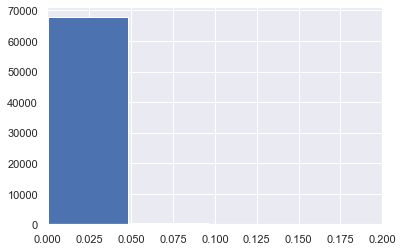

In [87]:
fig,ax = plt.subplots()
svi2016_withfires['fire_rate_per_capita'].hist(bins=30,ax=ax)
ax.set_xlim(0,.2)

In [88]:
svi2016_withfires[['fire_rate_per_capita','severe_fire_rate_per_capita']].describe()

,fire_rate_per_capita,severe_fire_rate_per_capita
count,68086.000000,68086.000000
mean,0.006250,0.001857
std,0.011160,0.003240
min,0.000064,0.000000
25%,0.002157,0.000511
50%,0.004077,0.001187
75%,0.007308,0.002263
max,1.450000,0.350000


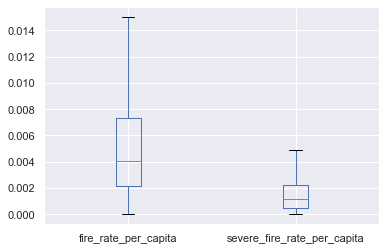

In [89]:
svi2016_withfires[['fire_rate_per_capita','severe_fire_rate_per_capita']].boxplot(showfliers=False)

In [90]:
def plot_correlation_matrix_heat_map(df,label,qty_fields=10):
    df = pd.concat([df[label],df.drop(label,axis=1)],axis=1)
    correlation_matrix = df.corr()
    index = correlation_matrix.sort_values(label, ascending=False).index
    correlation_matrix = correlation_matrix[index].sort_values(label,ascending=False)

    fig,ax = plt.subplots()
    fig.set_size_inches((10,10))
    sns.heatmap(correlation_matrix.iloc[:qty_fields,:qty_fields],annot=True,fmt='.2f',ax=ax)
    return(fig,ax)

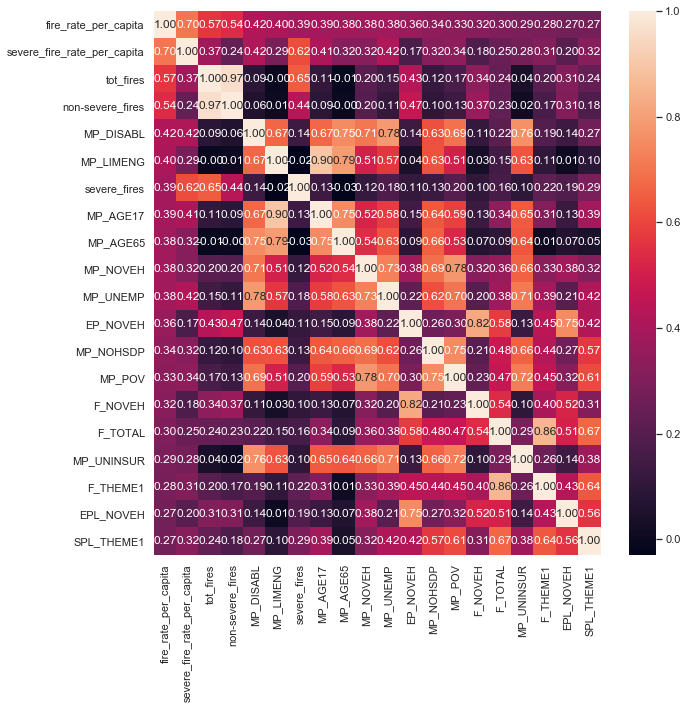

In [91]:
fig, ax = plot_correlation_matrix_heat_map(svi2016_withfires,'fire_rate_per_capita',qty_fields=20)

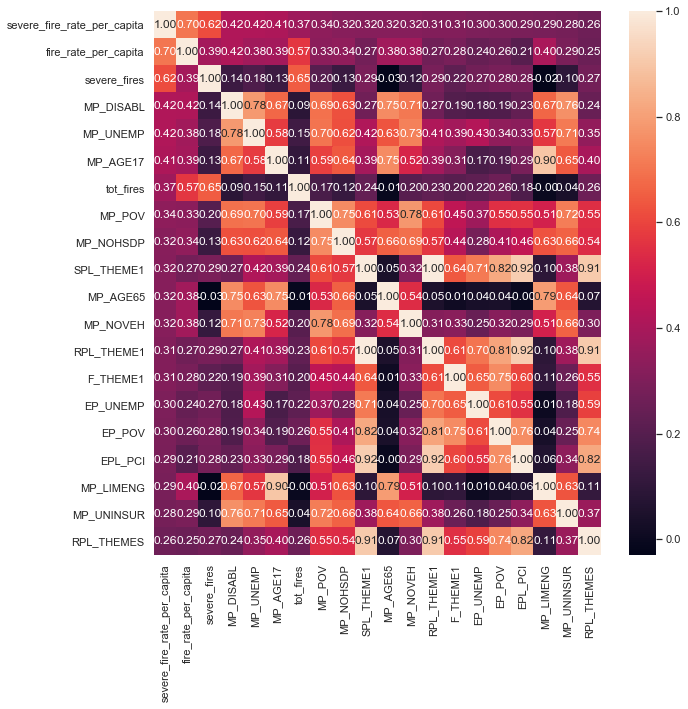

In [92]:
fig,ax = plot_correlation_matrix_heat_map(svi2016_withfires,'severe_fire_rate_per_capita',qty_fields=20)

So, looking at the two above heat maps, it seems that there are strong correlations between the per capita fire rates and the margins of error of a lot of the fields in the social vulnerability index. I can't think of why the fire rate would correlate more to the margin of error of something like the percentage of unemployed people, more than it correlates to the actual value of that percentage. Very weird.

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [94]:
not_features = ['ST','STATE','ST_ABBR','STCNTY','COUNTY','LOCATION','non-severe_fires','severe_fires',
                'tot_fires','fire_rate_per_capita','severe_fire_rate_per_capita']
features = svi2016_withfires.columns.drop(not_features)
label1 = 'fire_rate_per_capita'
label2 = 'severe_fire_rate_per_capita'

In [95]:
X1_train, X1_test, y1_train, y1_test = train_test_split(svi2016_withfires[features],svi2016_withfires[label1],random_state=0)

In [96]:
scaler = StandardScaler().fit(X1_train)
X1_train_scaled = scaler.transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)

In [97]:
lr = LinearRegression()
lr.fit()

TypeError: fit() missing 2 required positional arguments: 'X' and 'y'